In [1]:
import numpy as np
import random
from scipy.fft import fft, fftfreq
import jax
import jax.numpy as jnp
import optax
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.templates import StronglyEntanglingLayers
from IPython.display import clear_output
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import pandas

# Generate data

In [35]:
# Constants
NUM_POINTS = 2000
NUM_DIMENSIONS = 2
CUSTOM_DATASET = True

In [36]:
def generate_non_uniform_fourier_series(num_frequencies: int, max_frequency: float):
    """Generate function f(x) that returns a sum of cosines with
    random amplitudes, frequencies and phases."""
    
    frequencies = [max_frequency * np.random.random(NUM_DIMENSIONS) for _ in range(num_frequencies)]
    amplitudes = [random.random() for _ in range(num_frequencies)]
    phases = [2 * np.pi * random.random() for _ in range(num_frequencies)]
    # discontinuities = [NUM_POINTS * SAMPLE_SPACING * np.random.random(NUM_DIMENSIONS) for _ in range(num_frequencies)]
    print(f"Frequencies: {frequencies}")
    print(f"Amplitudes: {amplitudes}")
    print(f"Phases: {phases}")
    # print(f"Discontinuities: {discontinuities}")
    def f(x: np.ndarray):
        res = 0
        for frequency, amplitude, phase in zip(frequencies, amplitudes, phases):
            res += 1 * np.cos(np.dot(x, frequency) + phase)
        return res
    return f, frequencies

In [37]:
def generate_regression_data(inputs: np.ndarray, noise: float = 0):
    """Function used to generate noisy data."""
    data = np.array([f(input) for input in inputs])
    # add some random noise to data
    noisy_data = data + np.random.normal(0, noise, data.shape)
    return data, noisy_data

In [41]:
# Data
MAX_FREQUENCY = 10
if CUSTOM_DATASET:
    f, freqs = generate_non_uniform_fourier_series(num_frequencies=3, max_frequency=MAX_FREQUENCY)
    X = np.random.random((NUM_POINTS, NUM_DIMENSIONS)) * (100 / MAX_FREQUENCY)
    labels, Y = generate_regression_data(inputs=X, noise=0.1)
else:
    pp=pandas.read_csv('../data/synchronous_machine.csv', delimiter=";", decimal=",")
    data = pp.to_numpy()
    X = data[:, :-1]
    Y = data[:, -1]

Frequencies: [array([0.52002733, 9.19651995]), array([5.2068772 , 9.43212036]), array([1.79994861, 8.46521056])]
Amplitudes: [0.6952416615551089, 0.91652973834551, 0.633716722308083]
Phases: [4.0632718197590645, 0.2302068532249558, 4.668553333921296]


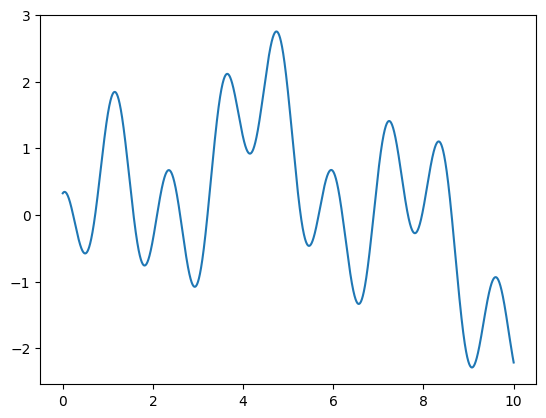

In [42]:
# Plot
if CUSTOM_DATASET:
    all_x = np.linspace(0, 100/ MAX_FREQUENCY, 10000)
    plt.plot(all_x, [f([x] + [0] * (NUM_DIMENSIONS - 1)) for x in all_x])
    plt.show()

# Compute cutoff frequency

In [43]:
# def centered_dft(data):
#     "computes the centered dft of a list of data values"
#     N=len(data)
#     M = np.array([[np.exp(-2j * np.pi * (i - (N - 1) / 2) * (j - (N - 1) / 2) / N) for i in range(N)] for j in range(N)])
#     dft=np.matmul(M,data)
#     return dft

In [44]:
# def inverse_centered_dft(data):
#     N=len(data)
#     def f(x):
#         M = np.array([np.exp(2j * np.pi * (x - (N - 1) / 2) * (j - (N - 1) / 2) / N) for j in range(N)])
#         dft = np.dot(M, data) / N
#         return dft
#     return f

In [45]:
# # CDFT
# y_dft = centered_dft(data=Y)
# x_dft = np.linspace(0, np.pi * (NUM_POINTS - 1) / NUM_POINTS, NUM_POINTS // 2 - 1)
# # Inverse
# y_inverse = inverse_centered_dft(data=y_dft)

In [46]:
# # Plot
# fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(8, 3))
# ax0.set_title("Centered discrete Fourier transform")
# ax0.plot(x_dft, np.abs(y_dft[NUM_POINTS // 2 + 1:]))
# ax1.set_title("Inverse") 
# ax1.plot([np.real(y_inverse(x)) for x in np.linspace(0, len(X), len(X) * 10)])
# plt.tight_layout()

In [47]:
# # Compute peaks of CDFT
# half_y_dft = np.abs(y_dft[NUM_POINTS // 2 + 1:])
# rel_height = 1/3
# max_height = np.max(half_y_dft)
# peak_indices, _ = find_peaks(half_y_dft, height=rel_height * max_height)
# if len(peak_indices) > 0:
#     max_peak_idx = np.max(peak_indices)
#     peak_width = peak_widths(x=half_y_dft, peaks=[max_peak_idx], rel_height=0.9)[0]
#     cutoff_frequency = np.max(x_dft[round(max_peak_idx + peak_width[0])])
# else:
#     cutoff_frequency = 0.1
# print(f"Cutoff frequency: {cutoff_frequency}")

# Random fourier features

In [48]:
gamma = 100
ndim = 1000
rbf_feature = RBFSampler(gamma=gamma, n_components=ndim, random_state=1)
X_features = rbf_feature.fit_transform(X)
weights = rbf_feature.random_weights_

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.33, random_state=42)
non_zero_coeffs = []
alpha = 1
MAX_NUM_FREQUENCIES = 10
while len(non_zero_coeffs) < MAX_NUM_FREQUENCIES:
    clear_output(wait=True)
    alpha /= 1.5
    print(f"alpha = {alpha}")
    clf = Lasso(alpha=alpha)
    clf.fit(X_train, Y_train)
    betas = clf.coef_
    non_zero_coeffs = betas[betas != 0]

print(f"Fitting score: {clf.score(X_test, Y_test)}")
print(f"Number of non-zero coefficients: {len(non_zero_coeffs)}")

alpha = 0.0022836582605211676
Fitting score: 0.5596413766998505
Number of non-zero coefficients: 10


In [50]:
# Filter coefficients
REL_THRESHOLD = 0.2
indices = np.abs(betas) >= np.max(np.abs(betas)) * REL_THRESHOLD
betas = betas[indices]
weights = weights[:, indices]

In [51]:
cutoff_frequencies = np.max(np.abs(weights), axis=1)
print(f"Cutoff freqs: {cutoff_frequencies}")
if CUSTOM_DATASET:
    print(f"Maximum freqs: {np.max(freqs, axis=0)}")

Cutoff freqs: [5.26733531 9.42700504]
Maximum freqs: [5.2068772  9.43212036]


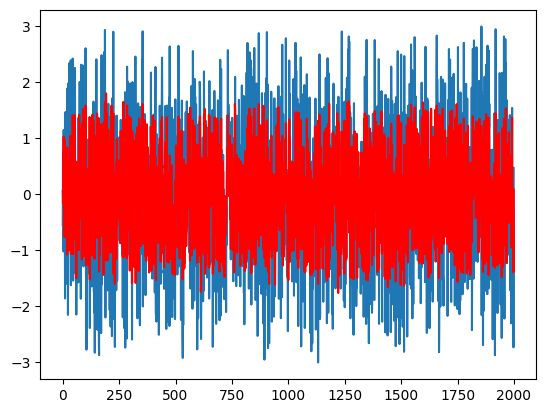

In [52]:
DIM = 1
plt.plot(Y)
plt.plot(clf.predict(X_features), color="red")

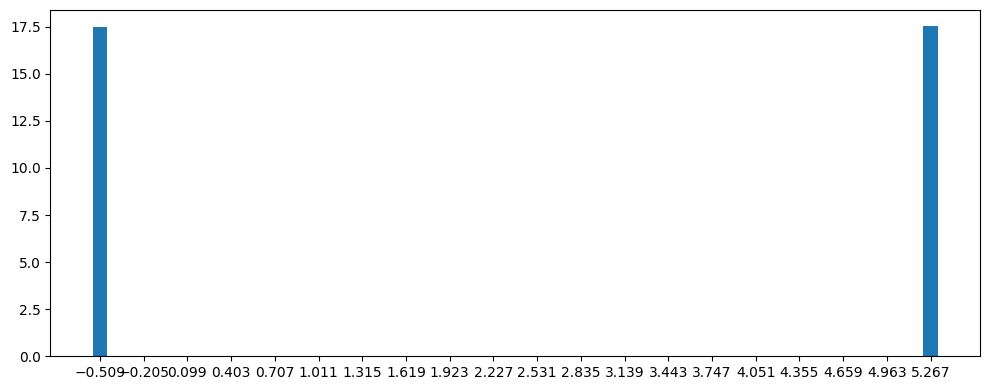

In [53]:
plt.figure(figsize=(10, 4))
plt.xticks(np.linspace(np.min(weights[0]), np.max(weights[0]), 20))
plt.bar(weights[0], np.abs(betas), width=0.1)
plt.tight_layout()

# Quantum model

In [54]:
NUM_LAYERS = 7

In [55]:
# Circuit
dev = qml.device("default.qubit", wires=NUM_DIMENSIONS)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights, scaling, input_data):
    for layer in range(NUM_LAYERS):
        StronglyEntanglingLayers(weights=weights[:-1], wires=list(range(NUM_DIMENSIONS)))
        for dim in range(NUM_DIMENSIONS):
            qml.RX(input_data[dim] * scaling[layer, dim],wires=dim)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit, (None, None, 0))

In [56]:
def square_loss(labels, predictions):
    """Square loss."""
    loss = jnp.sum((labels-predictions)**2)
    loss = loss/len(labels)
    return loss

In [57]:
def cost(params, input_data, labels):
    """Cost function."""
    predictions = variational_classifier(params['w'], params['s'], params['a'], input_data)
    return square_loss(labels, predictions)

In [58]:
def variational_classifier(weights, scaling, final_scaling, input_data):
    """Add classical bias."""
    return final_scaling * vcircuit(weights, scaling, input_data)

# Train model

In [59]:
# Training parameters
LR = 5e-2
if NUM_DIMENSIONS > 1:
    gammas = [cutoff_frequencies[i] / NUM_LAYERS for i in range(NUM_DIMENSIONS)]
else:
    gammas = cutoff_frequencies[0] / NUM_LAYERS
print(f"Gammas: {gammas}")
params = {'w': pnp.random.random((NUM_LAYERS, NUM_DIMENSIONS, 3),requires_grad=True),
          'a': pnp.ones(1, requires_grad=True),
          's':pnp.ones((NUM_LAYERS, NUM_DIMENSIONS),requires_grad=True) * gammas}

Gammas: [0.7524764725803771, 1.3467150057591617]


In [60]:
# Optimizer
optimizer = optax.adam(LR)
opt_state = optimizer.init(params)

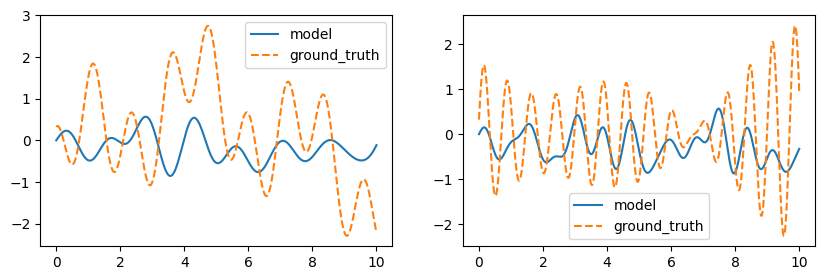

Iter:   991 | Cost: 1.3419665


In [61]:
# Train
if CUSTOM_DATASET:
    x_points = []
    y_points = []
    for i in range(NUM_DIMENSIONS):
        points = np.zeros((NUM_POINTS, NUM_DIMENSIONS))
        points[:, i] += np.linspace(0, 100 / MAX_FREQUENCY, NUM_POINTS)
        x_points.append(points)
        y_points.append(np.array([f(point) for point in points]))

for it in range(1000):
    cst, grads = jax.value_and_grad(cost)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state)
    # s_temp = params['s']
    params = optax.apply_updates(params, updates)
    # params['s']=s_temp
    
    if CUSTOM_DATASET:
        model_plot = [variational_classifier(params['w'], params['s'], params['a'], points) for points in x_points]
    if it%10==0:
        if CUSTOM_DATASET:
            clear_output(wait=True)
            fig, axes = plt.subplots(1, NUM_DIMENSIONS, figsize=(10, 3))
            axes = [axes] if NUM_DIMENSIONS == 1 else axes
            for i in range(NUM_DIMENSIONS):
                axes[i].plot(x_points[i][:, i], model_plot[i], label='model')
                axes[i].plot(x_points[i][:, i], y_points[i], linestyle='dashed',label='ground_truth')
                axes[i].legend()
            plt.show()
        print(f"Iter: {it + 1:5d} | Cost: {cst:0.7f}")